In [352]:
import pandas
import re
import numpy as np
world_data = pandas.read_csv("/Users/federicopigozzi/melTS/epa-sea-level_csv.csv", header=0)
world_data.drop(world_data.columns[4], axis=1, inplace=True)
for num in world_data.index:
    if num == 134:
        continue
    world_data.loc[num, "CSIRO Adjusted Sea Level"] = world_data.loc[num + 1, "CSIRO Adjusted Sea Level"] - world_data.loc[num, "CSIRO Adjusted Sea Level"]
    world_data.loc[num, "Lower Error Bound"] = world_data.loc[num + 1, "Lower Error Bound"] - world_data.loc[num, "Lower Error Bound"]
    world_data.loc[num, "Upper Error Bound"] = world_data.loc[num + 1, "Upper Error Bound"] - world_data.loc[num, "Upper Error Bound"]
world_data.drop(134, axis=0, inplace=True)
temperature_df = pandas.read_csv("/Users/federicopigozzi/melTS/annual_csv.csv", header=0)
temperature = list()
for num in temperature_df.index:
    if num > 268:
        break
    if num % 2 != 0:
        temperature.append((temperature_df.loc[num - 1, "Mean"] + temperature_df.loc[num, "Mean"]) / 2.0)
ice_data = pandas.read_csv("/Users/federicopigozzi/melTS/glaciers_csv.csv", header=0)
ice_data["Change"] = np.nan
for num in ice_data.index:
    if num == 69:
        ice_data.drop(num, axis=0, inplace=True)
    else:
        ice_data.loc[num, "Change"] = ice_data.loc[num + 1, "Mean cumulative mass balance"] - ice_data.loc[num, "Mean cumulative mass balance"]
for num in list(range(66)):
    world_data.drop(num, axis=0, inplace=True)
co2_data = pandas.read_csv("/Users/federicopigozzi/Downloads/global_csv.csv", header=0)
co2_data.drop(["Gas Fuel", "Liquid Fuel", "Solid Fuel", "Cement", "Gas Flaring", "Per Capita"], axis=1, inplace=True)
for num in co2_data.index:
    if num <= 193:
        co2_data.drop(num, axis=0, inplace=True)
co2_data.reset_index(inplace=True)
world_data.reset_index(inplace=True)
world_data["Mean Ice Mass Loss"] = ice_data["Change"]
world_data["Temp"] = temperature[::-1][66:]
for num in world_data.index:
    world_data.loc[num, "Year"] = world_data.loc[num, "Year"][0:4]
world_data = world_data.astype("float64")
for num in world_data.index:
    if world_data.loc[num, "Year"] > 2010:
        world_data.drop(num, axis=0, inplace=True)
world_data["co2"] = co2_data["Total"]
world_data = world_data.astype("float64")
world_data.drop("index", axis=1, inplace=True)

In [353]:
% pylab inline
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

Populating the interactive namespace from numpy and matplotlib


In [354]:
x = world_data["Year"]
y = world_data["Temp"]
extrapolation_temp = interp1d(x, y, kind="linear", fill_value="extrapolate")
xnew = pandas.DataFrame.from_dict({"x": [new_year for new_year in range(2010, 2100)]})
y = world_data["Mean Ice Mass Loss"]
extrapolation_ice = interp1d(x, y, kind="linear", fill_value="extrapolate")
y = world_data["co2"]
lregressor = LinearRegression()
lregressor.fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
extrapolation_co2 = lregressor.predict(xnew)
extrapolation_temp = [elem[0] for elem in extrapolation_temp(xnew)]
extrapolation_ice = [elem[0] for elem in extrapolation_ice(xnew)]
extrapolation_co2 = [elem[0] for elem in extrapolation_co2]
X_test = pandas.DataFrame.from_dict({"Mean Ice Mass Loss": extrapolation_ice, "Temp": extrapolation_temp, "co2": extrapolation_co2})

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


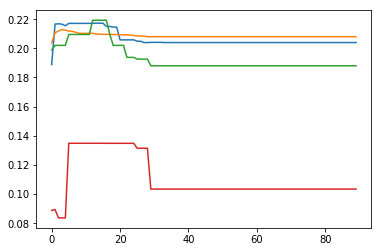

In [376]:
import sklearn
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor)
from sklearn.svm import SVC
import xgboost


training_data = world_data
ntrain = training_data.shape[0]
Y_train = training_data["Upper Error Bound"].values.reshape((65, 1))
X_train = training_data.drop(["CSIRO Adjusted Sea Level", "Year", "Upper Error Bound", "Lower Error Bound"], axis=1)
ntest = test_data.shape[0]
#print(Y_train.shape, X_train.shape, training_data.columns)
SEED = 0
FOLDS = 5
#print(X_train.shape, Y_train.shape, X_test.shape)
kfold = sklearn.model_selection.KFold(n_splits=FOLDS, random_state=SEED)
random_forest = RandomForestRegressor(n_estimators=575, warm_start=True, max_depth=5, min_samples_leaf=2, max_features="sqrt", random_state=SEED, verbose=False)
extra_trees = ExtraTreesRegressor(n_estimators=575, max_depth=5, min_samples_leaf=3, random_state=SEED, verbose=False)
ada_boost = AdaBoostRegressor(n_estimators=575, learning_rate=0.95, random_state=SEED)
gradient_boosting = GradientBoostingRegressor(n_estimators=575,  max_depth=5, min_samples_leaf=3, random_state=SEED, verbose=False)
base_predictions_train = pandas.DataFrame()
classifier_names = {random_forest: "Random_Forest", extra_trees: "Extra_Trees", ada_boost: "Ada_Boost", gradient_boosting: "Gradient_Boosting"}#, svc: "SVC"}
#train_x, test_x, train_y, test_y = sklearn.model_selection.train_test_split(training_data, Y, random_state=SEED)
for classifier in classifier_names.keys():
    classifier.fit(X_train, Y_train)
    predictions = classifier.predict(X_test)
    print(np.sum(classifier.predict(X_test)))
    #print(sklearn.metrics.mean_squared_error(test_y, temp_pred))
#train_list = list()
#test_list = list()
#for classifier in [random_forest, extra_trees, ada_boost, gradient_boosting]:#, svc]:
#    oof_train = numpy.zeros((ntrain,))
#    oof_test = numpy.zeros((ntest,))
#    oof_test_kf = numpy.zeros((FOLDS, ntest))
#    num = 0
#    for train_index, test_index in kfold.split(training_data):
#        x_tr = X_train.loc[train_index[0]:train_index[-1], :]
#        y_tr = Y_train[train_index]
#        x_te = X_train.loc[test_index[0]:test_index[-1], :]
#        classifier.fit(x_tr, y_tr)
#        oof_train[test_index] = classifier.predict(x_te)
#        oof_test_kf[num, :] = classifier.predict(X_test)
#        num += 1
#    oof_test[:] = oof_test_kf.mean(axis=0)
#    base_predictions_train[classifier_names[classifier]] = oof_train.reshape(-1, 1).ravel()
#    train_list.append(oof_train.reshape(-1, 1))
#    test_list.append(oof_test.reshape(-1, 1))
#x_train = numpy.concatenate([train for train in train_list], axis=1)
#x_test = numpy.concatenate([test for test in test_list], axis=1)
#booster = xgboost.XGBClassifier(n_estimators=5000, learning_rate=0.95, max_depth=4, min_child_weight=2,  gamma=1, subsample=0.8, colsample_by_tree=1, objective="binary:logistic", scale_pos_weight=1, silent=True)
#booster.fit(x_train, Y_train)
#predictions = booster.predict(x_test)
#plot(xnew, predictions)